In [1]:
from __future__ import print_function
import os
import numpy as np
import glob
from PIL import Image  
from random import *  
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import pandas as pd
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow
import tensorflow.keras
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

In [2]:
# fix random seed for reproducibility
np.random.seed(10)

In [4]:
#Use the flood_data.csv dataset
dataframe = pd.read_csv('dataset/flood_train.csv', usecols=[1], engine='python', skipfooter=3)
dataset   = dataframe.values
dataset   = dataset.astype('float32')
dataframe.head()

,Water Level
0,2.42
1,2.40
2,2.37
3,2.34
4,2.38


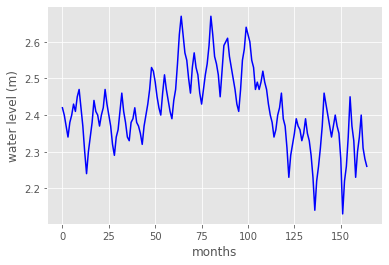

In [5]:
plt.plot(dataset, color="blue")
plt.xlabel('months')
plt.ylabel('water level (m)')

plt.show()


In [6]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [7]:
# split into train and test sets
train_size  = int(len(dataset) * 0.67)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


110 55


----------------- train data -----------------


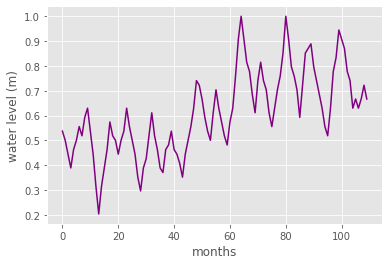

----------------- test data -----------------


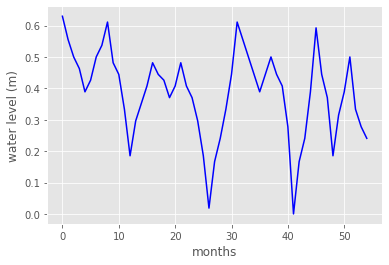

In [8]:
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- train data -----------------')
plt.plot(train, color="purple")
plt.xlabel('months')
plt.ylabel('water level (m)')
plt.show()

plt.show()
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- test data -----------------')
plt.plot(test, color="blue")
plt.xlabel('months')
plt.ylabel('water level (m)')
plt.show()


In [9]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)


In [10]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)


In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [12]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',)
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2,)


Epoch 1/50
99/99 - 16s - loss: 0.2511
Epoch 2/50
99/99 - 0s - loss: 0.0265
Epoch 3/50
99/99 - 0s - loss: 0.0156
Epoch 4/50
99/99 - 0s - loss: 0.0146
Epoch 5/50
99/99 - 0s - loss: 0.0135
Epoch 6/50
99/99 - 0s - loss: 0.0127
Epoch 7/50
99/99 - 0s - loss: 0.0122
Epoch 8/50
99/99 - 0s - loss: 0.0113
Epoch 9/50
99/99 - 0s - loss: 0.0102
Epoch 10/50
99/99 - 0s - loss: 0.0096
Epoch 11/50
99/99 - 0s - loss: 0.0093
Epoch 12/50
99/99 - 0s - loss: 0.0087
Epoch 13/50
99/99 - 0s - loss: 0.0080
Epoch 14/50
99/99 - 0s - loss: 0.0080
Epoch 15/50
99/99 - 0s - loss: 0.0076
Epoch 16/50
99/99 - 0s - loss: 0.0070
Epoch 17/50
99/99 - 0s - loss: 0.0071
Epoch 18/50
99/99 - 0s - loss: 0.0068
Epoch 19/50
99/99 - 0s - loss: 0.0068
Epoch 20/50
99/99 - 0s - loss: 0.0064
Epoch 21/50
99/99 - 0s - loss: 0.0062
Epoch 22/50
99/99 - 0s - loss: 0.0061
Epoch 23/50
99/99 - 0s - loss: 0.0058
Epoch 24/50
99/99 - 0s - loss: 0.0057
Epoch 25/50
99/99 - 0s - loss: 0.0054
Epoch 26/50
99/99 - 0s - loss: 0.0057
Epoch 27/50
99/99 - 

In [13]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % testScore)




Train Score: 2.17 RMSE
Test Score: 2.19 RMSE


In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


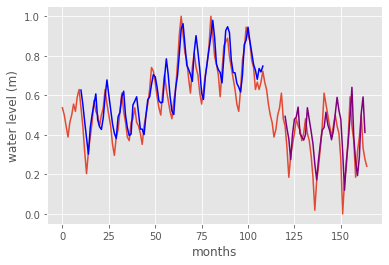

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict) + slide_window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (slide_window * 2) + 1:len(dataset) - 1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot, color="blue")
plt.plot(testPredictPlot, color="purple")
plt.xlabel('months')
plt.ylabel('water level (m)')
plt.show()


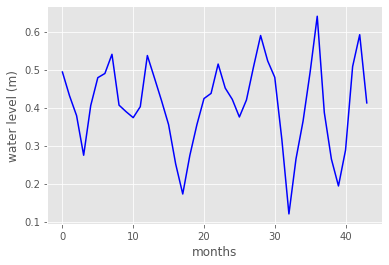

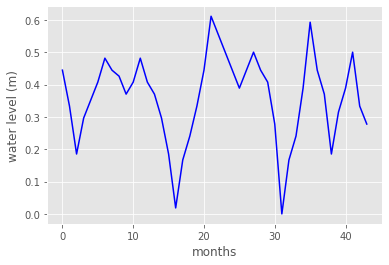

In [16]:
plt.plot(testPredict, color="blue")
plt.xlabel('months')
plt.ylabel('water level (m)')
plt.show()

plt.plot(testY, color="blue")
plt.xlabel('months')
plt.ylabel('water level (m)')
plt.show()


In [18]:
# Test the network on an unseen dataset
unseen = pd.read_csv('dataset/flood_test.csv',sep=',')


In [19]:
unseen.head()

,date,Water Level
0,20/02/2015,2.31
1,21/02/2015,2.33
2,22/02/2015,2.36
3,23/02/2015,2.32
4,24/02/2015,2.30


In [21]:
unseen_test = unseen['Water Level'].values



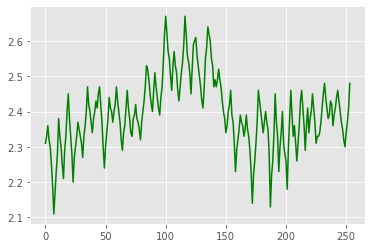

In [22]:
plt.plot(unseen_test[0:20000], color="green")

In [23]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)


In [24]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, 2430)



In [25]:
unseen_results = model.predict(testX)

-------------------- Predicted --------------------


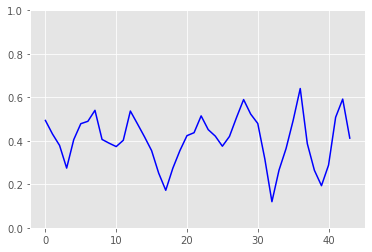

-------------------- Ground Truth --------------------


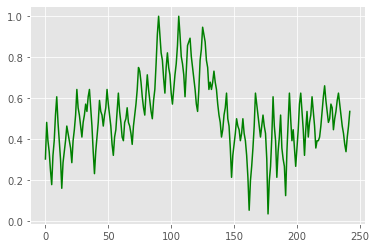

In [26]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results[0:20000], color="blue")
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels, color="green")
plt.show()



The value of R-squared of water level is  -0.040830578524268635


Text(0, 0.5, 'water level (m)')

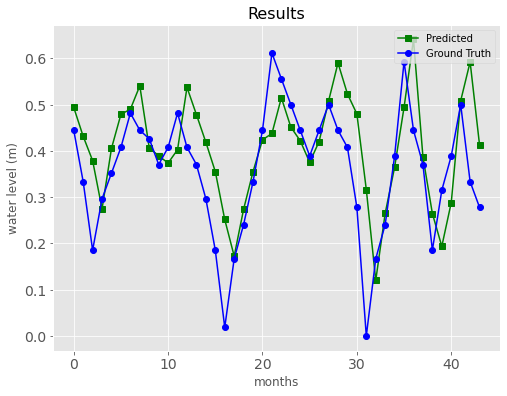

In [28]:

print('The value of R-squared of water level is ', r2_score(unseen_results, testY))

f, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(unseen_results, color="green", linestyle="-", marker="s", linewidth=1.5, label="Predicted")

plt.plot(testY, color="blue", linestyle="-", marker="o", linewidth=1.5, label="Ground Truth")

ax1.set_title('Results', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('months')
plt.ylabel('water level (m)')

